<a href="https://colab.research.google.com/github/JayPiRDD/TransferPetModel/blob/main/TransferPetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Célula 1

🔧 Importação de bibliotecas e definição de constantes

Nesta célula, importamos as bibliotecas principais que serão usadas ao longo do projeto:

tensorflow e tensorflow.keras para construir e treinar o modelo.

tensorflow_datasets para carregar datasets prontos.

matplotlib.pyplot para visualização.

Também definimos três constantes:

IMG_SIZE: o tamanho das imagens que será usado como entrada da rede (224x224 pixels).

BATCH_SIZE: o número de imagens processadas por vez.

EPOCHS: número de épocas para o treinamento do modelo.



In [7]:
# Importamos as bibliotecas necessárias para trabalhar com TensorFlow,
# modelos, camadas e datasets.
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Definimos o tamanho das imagens que o MobileNetV2 espera (224x224)
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5


#Célula 2
📥 Carregamento e preparação do dataset Cats vs Dogs

Nesta célula, realizamos o carregamento e a preparação dos dados para treino e validação:

Carregamento: Utilizamos tfds.load() para carregar o dataset cats_vs_dogs, com as_supervised=True para obter pares (imagem, rótulo).

Divisão: O conjunto de dados original é dividido em 80% para treino e 20% para validação, com shuffle() para embaralhar antes da divisão.

Redimensionamento e Normalização: Criamos a função preprocess() para redimensionar as imagens para 160x160 e normalizá-las para o intervalo [0, 1].

Pipeline de dados: Aplicamos a função de preprocessamento com map(), organizamos os dados em batches e usamos prefetch() para performance.

Impressão de informações: Exibimos as informações básicas do dataset, como número total de imagens e tamanho de cada divisão.



In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds

# 1. Carregamos o dataset 'cats_vs_dogs' com TensorFlow Datasets
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
all_data = dataset['train']

# 2. Embaralhar e dividir em treino e validação (80% treino, 20% validação)
total_count = info.splits['train'].num_examples
train_size = int(0.8 * total_count)

all_data = all_data.shuffle(1000, seed=42)
train_data = all_data.take(train_size)
val_data = all_data.skip(train_size)

# 3. Definir tamanho da imagem e batch
IMG_SIZE = 160
BATCH_SIZE = 32

# 4. Função para redimensionar e normalizar imagens
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

# 5. Aplicar preprocessamento, batching e prefetch nos dados
train_data = train_data.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = val_data.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 6. Exibir informações básicas do dataset
print(info)
print(f"Total de imagens: {total_count}")
print(f"Tamanho do treino: {train_size}")
print(f"Tamanho da validação: {total_count - train_size}")


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, Jo

#Célula 3
🔍 Inspeção dos dados de treino

Nesta célula, selecionamos uma imagem e seu rótulo do conjunto de treino para inspeção:

Extraímos a primeira imagem e seu rótulo do batch.

Verificamos o tipo de dado (dtype) da imagem para confirmar que está no formato float32.

Conferimos o valor mínimo e máximo dos pixels para garantir que estão normalizados entre 0 e 1.

Exibimos o formato (shape) da imagem, que deve ser (160, 160, 3), confirmando que a imagem tem 160x160 pixels e 3 canais de cor (RGB).

In [22]:
for images, labels in train_data.take(1):
    image = images[0]
    label = labels[0]
    print(f"Dtype da imagem: {image.dtype}")
    print(f"Min valor da imagem: {tf.reduce_min(image).numpy()}")
    print(f"Max valor da imagem: {tf.reduce_max(image).numpy()}")
    print(f"Shape da imagem: {image.shape}")


Dtype da imagem: <dtype: 'float32'>
Min valor da imagem: 0.021112898364663124
Max valor da imagem: 1.0
Shape da imagem: (160, 160, 3)


#Célula 4
🖼️ Visualização de uma imagem de treino

Neste bloco exibimos uma imagem do conjunto de treino já pré-processada (redimensionada e normalizada). A imagem é mostrada com seu respectivo rótulo (0 para gato, 1 para cachorro). O matplotlib aceita imagens com valores float entre 0 e 1, por isso não é necessário converter.

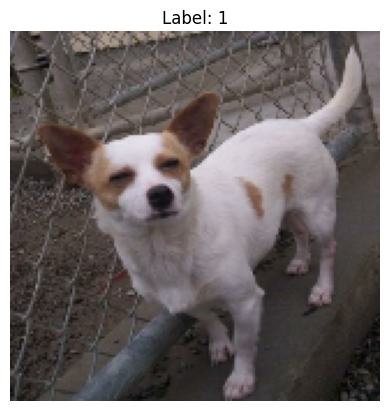

In [23]:
for images, labels in train_data.take(1):
    image = images[0]
    label = labels[0]
    plt.imshow(image)  # matplotlib aceita float [0,1] e mostra certinho
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')
    plt.show()


#Célula 5
🔀 Divisão simples do dataset em treino e validação

Neste trecho, dividimos o dataset original em duas partes:

Os primeiros 2000 exemplos são usados para treino (train_data).

Os próximos 1000 exemplos são usados para validação (val_data).

Essa divisão é feita para separar dados para treinamento do modelo e dados para avaliar o desempenho dele durante o treino.

In [10]:
# Dividir o dataset em treino e validação (exemplo)
train_data = dataset['train'].take(2000)     # primeiros 2000 exemplos para treino
val_data = dataset['train'].skip(2000).take(1000)  # próximos 1000 para validação


#Célula 6
🛠️ Função de pré-processamento das imagens

Esta função preprocess prepara cada imagem do dataset para o modelo MobileNetV2:

Redimensiona a imagem para o tamanho esperado pelo modelo (160x160 pixels).

Normaliza os valores dos pixels para o intervalo entre 0 e 1, facilitando o treinamento.

O pré-processamento garante que todas as imagens tenham o formato e escala corretos para a rede neural.

In [11]:
IMG_SIZE = 160  # tamanho esperado pela MobileNetV2

def preprocess(image, label):
    # Redimensiona a imagem para 160x160
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Normaliza os pixels para intervalo [0, 1]
    image = image / 255.0
    return image, label


#Célula 7
🔄 Preparação dos batches de dados para treino e validação

Define o tamanho do batch (BATCH_SIZE = 32), ou seja, quantas imagens serão processadas por vez.

Aplica o pré-processamento (função preprocess) nas imagens de treino e validação.

Agrupa as imagens em batches de 32 para otimizar o processamento.

Usa o método prefetch(1) para carregar os dados seguintes enquanto o modelo treina, aumentando a eficiência.

In [12]:
BATCH_SIZE = 32

train_batches = train_data.map(preprocess).batch(BATCH_SIZE).prefetch(1)
val_batches = val_data.map(preprocess).batch(BATCH_SIZE).prefetch(1)


#Célula 8
🏗️ Construção do modelo com Transfer Learning usando MobileNetV2

Importamos a arquitetura MobileNetV2 pré-treinada no ImageNet, que já aprendeu a extrair características visuais úteis.

Configuramos include_top=False para remover a última camada de classificação original, pois vamos adaptar para nosso problema binário (gato vs cachorro).

Congelamos as camadas da base, para que os pesos pré-treinados não sejam atualizados no treino inicial (evita sobreajuste e acelera).

Adicionamos uma camada de Global Average Pooling para converter mapas de características em um vetor fixo.

Acrescentamos a camada de saída com ativação sigmóide, que retorna a probabilidade de ser gato ou cachorro.

Finalmente, compilamos o modelo definindo o otimizador Adam, a função de perda binária (crossentropy) e a métrica de acurácia.

In [13]:
import tensorflow as tf

# Carregar a base MobileNetV2 pré-treinada no ImageNet, sem a camada final (top=False)
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# Congelar as camadas para não treinar os pesos da base
base_model.trainable = False

# Construir a cabeça do modelo
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')  # saída binária (gato ou cachorro)

# Montar o modelo completo
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

# Compilar o modelo
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#Célula 9
🚀 Treinamento do modelo

Definimos o número de épocas como 5, ou seja, o modelo irá passar 5 vezes por todo o conjunto de treino.

Usamos o método fit para treinar o modelo com os dados em train_batches.

Durante o treinamento, o modelo também será avaliado a cada época no conjunto de validação val_batches para acompanhar seu desempenho.

O histórico do treinamento, contendo métricas como perda e acurácia em treino e validação, será armazenado na variável history.

In [14]:
EPOCHS = 5  # número de vezes que o modelo vai ver todo o dataset

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=val_batches
)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8233 - loss: 0.3768 - val_accuracy: 0.9590 - val_loss: 0.1123
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9737 - loss: 0.0835 - val_accuracy: 0.9680 - val_loss: 0.0895
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9859 - loss: 0.0603 - val_accuracy: 0.9720 - val_loss: 0.0807
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9916 - loss: 0.0484 - val_accuracy: 0.9730 - val_loss: 0.0764
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9931 - loss: 0.0407 - val_accuracy: 0.9720 - val_loss: 0.0740


#Célula 10
📊 Avaliação do modelo e visualização de dados

Avaliamos o desempenho do modelo no conjunto de validação usando o método evaluate, que retorna a loss (perda) e a accuracy (acurácia).

Em seguida, mostramos uma imagem do conjunto de validação para visualizar como os dados estão, junto com seu rótulo verdadeiro ("Gato" ou "Cachorro").

Também imprimimos algumas informações técnicas da imagem (tipo, valores mínimos e máximos, e formato), para garantir que o pré-processamento está correto.

146/146 ━━━━━━━━━━━━━━━━━━━━ 111s 621ms/step - accuracy: 0.9727 - loss: 0.0730
Loss no conjunto de validação: 0.0817
Acurácia no conjunto de validação: 0.9688
Dtype da imagem: <dtype: 'float32'>
Min valor da imagem: 0.0
Max valor da imagem: 1.0
Shape da imagem: (160, 160, 3)


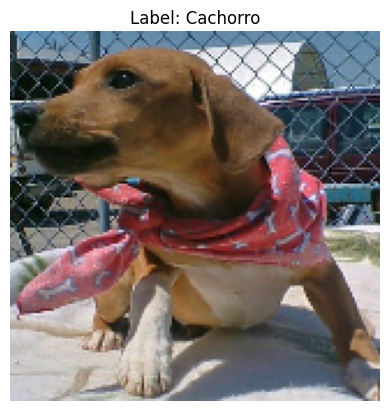

In [27]:
# Avaliação do modelo no conjunto de validação
loss, accuracy = model.evaluate(val_data)
print(f"Loss no conjunto de validação: {loss:.4f}")
print(f"Acurácia no conjunto de validação: {accuracy:.4f}")

# Visualização de uma imagem do conjunto de validação
for images, labels in val_data.take(1):
    img = images[0]  # Pegamos a primeira imagem do batch
    label = labels[0].numpy()

    # Informações sobre a imagem
    print(f"Dtype da imagem: {img.dtype}")
    print(f"Min valor da imagem: {tf.reduce_min(img).numpy()}")
    print(f"Max valor da imagem: {tf.reduce_max(img).numpy()}")
    print(f"Shape da imagem: {img.shape}")

    # Exibe a imagem com o rótulo correspondente
    plt.imshow(img)
    plt.title(f"Label: {'Cachorro' if label == 1 else 'Gato'}")
    plt.axis('off')
    plt.show()


#Célula 11
🤖 Previsão com o modelo treinado

Pegamos uma imagem do conjunto de validação para testar a previsão do modelo.

Expandimos as dimensões da imagem para criar um batch com tamanho 1, pois o modelo espera um lote de imagens.

O modelo gera uma saída entre 0 e 1 (por causa da ativação sigmoid e loss binária).

Definimos o limiar de 0.5 para decidir se é gato (0) ou cachorro (1).

Exibimos a imagem com o rótulo previsto e o rótulo real, para comparar.

Também mostramos o valor bruto da previsão, que indica a "confiança" do modelo.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


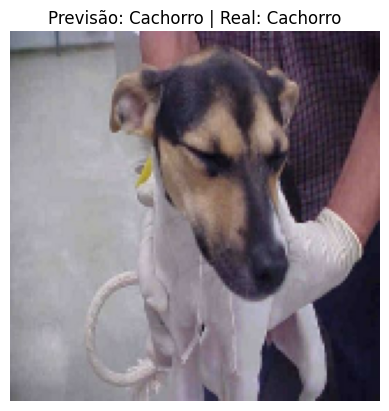

Valor bruto da previsão: 0.9979


In [28]:
# Pegamos uma imagem do conjunto de validação
for images, labels in val_data.take(1):
    img = images[0]  # Primeira imagem do batch
    true_label = labels[0].numpy()

    # Precisamos adicionar uma dimensão extra para prever (batch size = 1)
    img_expanded = tf.expand_dims(img, axis=0)

    # Fazemos a previsão
    prediction = model.predict(img_expanded)

    # Como usamos binary_crossentropy, a saída será um valor entre 0 e 1
    predicted_label = 1 if prediction[0][0] > 0.5 else 0

    # Exibe a imagem com a previsão
    plt.imshow(img)
    plt.title(f"Previsão: {'Cachorro' if predicted_label == 1 else 'Gato'} | Real: {'Cachorro' if true_label == 1 else 'Gato'}")
    plt.axis('off')
    plt.show()

    print(f"Valor bruto da previsão: {prediction[0][0]:.4f}")


#Célula 12
🐱🐶 Visualizando 10 imagens do conjunto de validação (5 gatos e 5 cachorros)

Percorremos o conjunto de validação para selecionar 5 imagens de gatos e 5 de cachorros.

Usamos um contador para garantir a quantidade desejada de cada classe.

As imagens são exibidas em uma grade 2x5, com o título indicando se é gato ou cachorro.

Essa visualização ajuda a entender melhor como os dados estão distribuídos e verificar exemplos reais.

In [31]:
import matplotlib.pyplot as plt

# Mapeamento de rótulos numéricos para texto
class_names = ['Gato', 'Cachorro']

# Inicializa contadores
cat_count = 0
dog_count = 0
max_per_class = 5

plt.figure(figsize=(15, 8))
i = 0

# Percorre o dataset de validação
for image, label in val_data.unbatch():
    label_val = label.numpy()

    # Se já temos 5 de cada, para
    if cat_count >= max_per_class and dog_count >= max_per_class:
        break

    # Se ainda precisa de gatos e encontrou um
    if label_val == 0 and cat_count < max_per_class:
        i += 1
        cat_count += 1
    # Se ainda precisa de cachorros e encontrou um
    elif label_val == 1 and dog_count < max_per_class:
        i += 1
        dog_count += 1
    else:
        continue

    # Plota a imagem
    plt.subplot(2, 5, i)
    plt.imshow(image.numpy())
    plt.title(class_names[label_val])
    plt.axis('off')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

<Figure size 1500x800 with 0 Axes>